In [1]:
!nvidia-smi

Sun Apr 20 05:06:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8             15W /  200W |    7400MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install thop

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
from datetime import timedelta
from thop import profile


from utils import get_device, get_dataloaders
from utils import clear_gpu_memory, get_gpu_memory

from VGG import VGG
from VGG_BN import VGG_BN
from ResNet import get_model

### Load models

In [2]:
def evaluate(model, loader, criterion, device):
    model.to(device).eval()

    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            total_loss += criterion(out,y).item() * x.size(0)
            preds = out.argmax(1)
            correct   += (preds==y).sum().item()
            total     += y.size(0)
    return total_loss/total, correct/total

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def compute_flops(model, in_channels, img_size, device):
    model.to(device).eval()
    dummy = torch.randn(1, in_channels, img_size, img_size).to(device)
    macs, _ = profile(model, inputs=(dummy,), verbose=False)
    # thop gives MACs → FLOPs ≈ 2*MACs
    return 2*macs

def measure_latency(model, loader, device, n_warmup=10, n_runs=50):
    model.to(device).eval()
    it = iter(loader)
    # warm‑up
    for _ in range(n_warmup):
        x,_ = next(it)
        _ = model(x.to(device))
    # timed
    start = time.time()
    for _ in range(n_runs):
        x,_ = next(it)
        _ = model(x.to(device))
    end = time.time()
    # avg ms per batch
    return (end - start)/n_runs * 1000


In [3]:
device = get_device()
clear_gpu_memory()
get_gpu_memory()

experiments = []

for arch in ['vgg16','vgg19']:

    model = VGG(arch)
    vgg_path = f"vgg_results/mnist_{arch}_scratch_model.pth"
    model.load_state_dict(torch.load(vgg_path, weights_only=True))
    experiments.append((f"{arch.upper()} (plain)", model, 'MNIST'))

    model = VGG(arch)
    vgg_path = f"vgg_results/cifar10_{arch}_scratch_model.pth"
    model.load_state_dict(torch.load(vgg_path, weights_only=True))
    experiments.append((f"{arch.upper()} (plain)", model, 'CIFAR10'))


    model_b = VGG_BN(arch)
    vgg_path = f"vgg_bottleneck_results/mnist_bottleneck_{arch}_scratch_model.pth"
    model_b.load_state_dict(torch.load(vgg_path, weights_only=True))
    experiments.append((f"{arch.upper()}_BN", model_b, 'MNIST'))

    model_b = VGG_BN(arch)
    vgg_path = f"vgg_bottleneck_results/cifar10_bottleneck_{arch}_scratch_model.pth"
    model_b.load_state_dict(torch.load(vgg_path, weights_only=True))
    experiments.append((f"{arch.upper()}_BN", model_b, 'CIFAR10'))

    
# ResNets
for depth in [18,50]:
              # 101]:
    for ds in ['mnist','cifar10']:
        model = get_model(arch=f'resnet{depth}', num_classes=10, device=device, pretrained=False)
        model.load_state_dict(torch.load(f"resnet_results/{ds}_resnet{depth}_scratch_model.pth",
                                         map_location=device))
        experiments.append((f"ResNet{depth}", model, ds.upper()))

GPU memory allocated: 0.00 GB
GPU memory reserved: 0.00 GB


In [4]:
experiments

[('VGG16 (plain)',
  VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [5]:
results = []
criterion = nn.CrossEntropyLoss()
ch, sz = 3, 32
for name, model, ds in experiments:
    train_dl, test_dl, n_cls = get_dataloaders(ds, batch_size=128)
    loss, acc    = evaluate(model, test_dl, criterion, device)
    tot_p, trn_p = count_params(model)
    flops        = compute_flops(model, ch, sz, device)
    lat_ms       = measure_latency(model, test_dl, device)
    results.append({
        'Model':     name,
        'Dataset':   ds,
        'Loss':      loss,
        'Accuracy':  acc,
        'Params':    tot_p,
        'Trainable': trn_p,
        'FLOPs':     flops,
        'Latency_ms':lat_ms
    })

df = pd.DataFrame(results)
print(df)


            Model  Dataset      Loss  Accuracy    Params  Trainable  \
0   VGG16 (plain)    MNIST  0.019255    0.9944  14728266   14728266   
1   VGG16 (plain)  CIFAR10  0.572969    0.8493  14728266   14728266   
2        VGG16_BN    MNIST  0.015713    0.9960   6103578    6103578   
3        VGG16_BN  CIFAR10  0.628937    0.8348   6103578    6103578   
4   VGG19 (plain)    MNIST  0.021749    0.9946  20040522   20040522   
5   VGG19 (plain)  CIFAR10  0.458821    0.8730  20040522   20040522   
6        VGG19_BN    MNIST  0.015660    0.9948   1423770    1423770   
7        VGG19_BN  CIFAR10  0.644614    0.8183   1423770    1423770   
8        ResNet18    MNIST  0.018019    0.9953  11181642   11181642   
9        ResNet18  CIFAR10  0.642004    0.8352  11181642   11181642   
10       ResNet50    MNIST  0.020318    0.9946  23528522   23528522   
11       ResNet50  CIFAR10  0.602436    0.8433  23528522   23528522   

          FLOPs  Latency_ms  
0   628620288.0   12.419481  
1   628620288.0 

In [23]:
# df1 = df.where(df['Dataset'] == "MNIST").dropna().sort_values("FLOPs", ascending=False)
# df1

In [7]:
def format_num(num, is_flops=False):
    if is_flops:
        return f"{round(num/1e6)}M"
    return f"{round(num/1e6, 1)}M" if num >= 1e6 else f"{round(num/1e3, 1)}K"



def build_table(df1):
    data = {
        'Model': df1["Model"],
        'Dataset': df1['Dataset'],
        'Loss': df1["Loss"],
        'Accuracy': df1["Accuracy"],
        'Params': df1["Params"],
        'Trainable': df1["Trainable"],
        'FLOPs': df1["FLOPs"],
        'Latency_ms': df1["Latency_ms"]
    }
    
    df = pd.DataFrame(data)


    selected_models = {
        'VGG16 (plain)': 'VGG-16',
        'VGG19 (plain)': 'VGG-19',
        'ResNet18': 'ResNet-18',
        'ResNet50': 'ResNet-50',
        'VGG16_BN': 'VGG16-BN (Ours)',
        'VGG19_BN': 'VGG19-BN (Ours)'
    }
    
    
    metrics = ['Parameters', 'FLOPs', 'Acc']
    new_df = pd.DataFrame(index=metrics, columns=selected_models.values())

    for orig_name, new_name in selected_models.items():
        model_data = df[df['Model'] == orig_name].iloc[0]

        new_df.loc['Parameters', new_name] = format_num(model_data['Params'])

        new_df.loc['FLOPs', new_name] = format_num(model_data['FLOPs'], is_flops=True)

        new_df.loc['Acc', new_name] = f"{model_data['Accuracy']*100:.1f}"

    return new_df
    


In [9]:
df1 = df.where(df['Dataset'] == "MNIST").dropna().sort_values("FLOPs", ascending=False)
df1
new_df = build_table(df1)
new_df.reset_index(inplace=True)
new_df.rename(columns={'index': 'Metric'}, inplace=True)

new_df.to_csv("mnist_comperison.csv")
new_df.head()

,Metric,VGG-16,VGG-19,ResNet-18,ResNet-50,VGG16-BN (Ours),VGG19-BN (Ours)
0,Parameters,14.7M,20.0M,11.2M,23.5M,6.1M,1.4M
1,FLOPs,629M,799M,74M,169M,218M,69M
2,Acc,99.5,99.3,99.5,99.5,99.4,99.4


In [8]:
df1 = df.where(df['Dataset'] != "MNIST").dropna().sort_values("FLOPs", ascending=False)
df1
new_df = build_table(df1)
new_df.reset_index(inplace=True)
new_df.rename(columns={'index': 'Metric'}, inplace=True)

new_df.to_csv("cifar10_comperison.csv")
new_df.head()

,Metric,VGG-16,VGG-19,ResNet-18,ResNet-50,VGG16-BN (Ours),VGG19-BN (Ours)
0,Parameters,14.7M,20.0M,11.2M,23.5M,6.1M,1.4M
1,FLOPs,629M,799M,74M,169M,218M,69M
2,Acc,84.9,87.3,83.5,84.3,83.5,81.8


<Figure size 800x400 with 0 Axes>

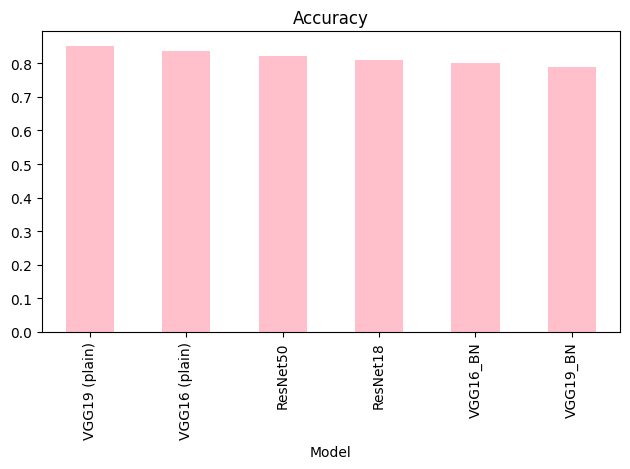

<Figure size 800x400 with 0 Axes>

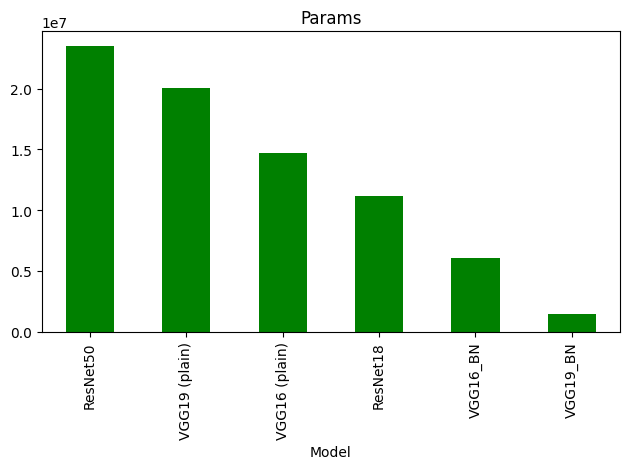

<Figure size 800x400 with 0 Axes>

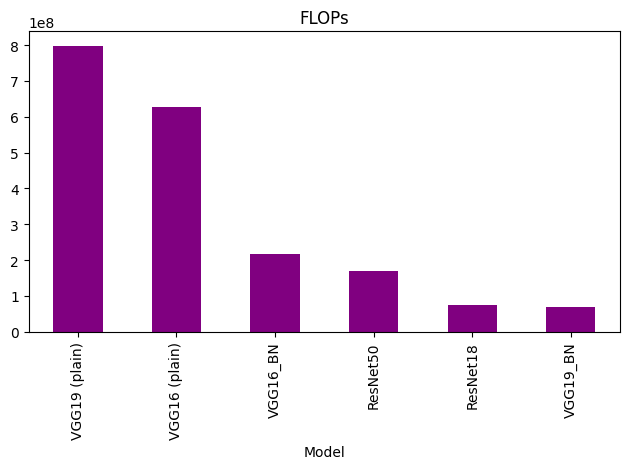

<Figure size 800x400 with 0 Axes>

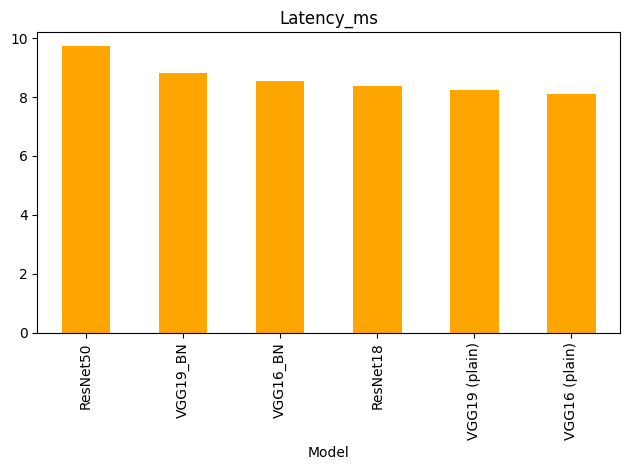

In [34]:

metrics = ['Accuracy','Params','FLOPs','Latency_ms']
colors = ["pink", "green", "purple", "orange"]
for i, m in enumerate(metrics):
    plt.figure(figsize=(8,4))
    sorted_df = df1.sort_values(m, ascending=False)
    sorted_df.plot.bar(x='Model', y=m, legend=False, color=colors[i])
    plt.title(m)
    plt.tight_layout()
    plt.show()


### Errors

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [10]:
def evaluate(model, loader, criterion, device):
    model.to(device).eval()

    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            total_loss += criterion(out,y).item() * x.size(0)
            preds = out.argmax(1)
            correct   += (preds==y).sum().item()
            total     += y.size(0)
    return total_loss/total, correct/total

def get_predictions(model, data_loader, device):
    model.to(device).eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds  = outputs.argmax(dim=1)
            true_labels.extend(y.cpu().numpy().tolist())
            pred_labels.extend(preds.cpu().numpy().tolist())

    return true_labels, pred_labels


def plot_reports(class_names, y_true, y_pred, name, ds):
    target_names = [f"{i}" for i in range(len(class_names))]

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    disp.plot()
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=class_names))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(f"cls_report/{ds}_{name}.csv")

def visual_fails(y_pred, y_true, test_data, model):
    wrong_index = (np.array(y_pred) != np.array(y_true)).nonzero()
    test_data = test_data.dataset
    ds_classes = test_data.classes
    
    plt.figure(figsize=(12, 6))
    plot_num = 0
    
    for i in wrong_index[0][:6]:
    
        data, target = test_data[i]
        image = data.unsqueeze(0).to(device)  # add batch dimention
        with torch.no_grad():
            pred = model(image).argmax(dim=1).item()
        plt.subplot(2, 3, plot_num + 1)  # Subplot indices start at 1
        image_to_plot = data.permute(1, 2, 0).cpu().numpy()

        plt.imshow(image_to_plot)
        plt.title(f'True: {ds_classes[target]}\nPred: {ds_classes[pred]}')
        plt.axis('off')
    
        plot_num+=1
    plt.tight_layout()
    plt.show()



Model - $VGG16 (plain)
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


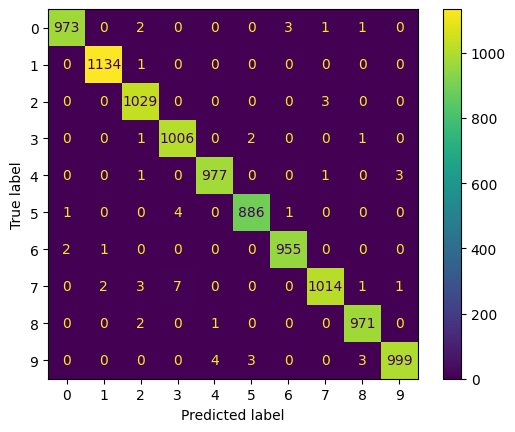

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.790561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.4492853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].


              precision    recall  f1-score   support

    0 - zero       1.00      0.99      0.99       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       0.99      1.00      0.99      1032
   3 - three       0.99      1.00      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      1.00      1.00       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       0.99      1.00      1.00       974
    9 - nine       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



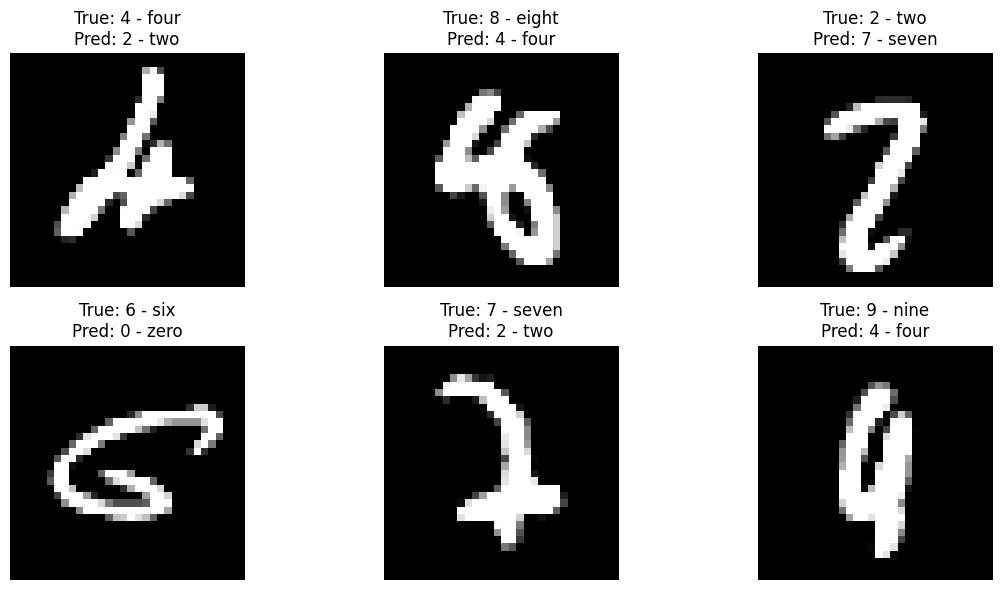

Model - $VGG16_BN
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


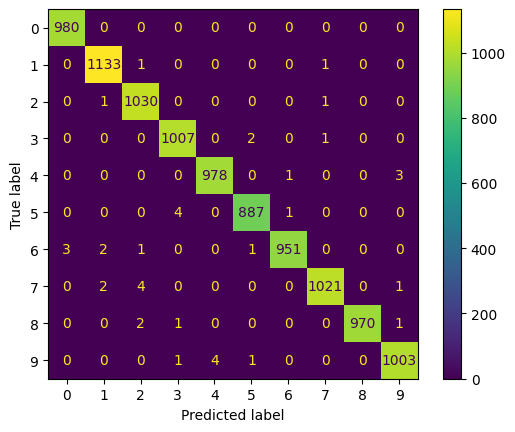

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8121893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8198957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7818604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8029413].


              precision    recall  f1-score   support

    0 - zero       1.00      1.00      1.00       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       0.99      1.00      1.00      1032
   3 - three       0.99      1.00      1.00      1010
    4 - four       1.00      1.00      1.00       982
    5 - five       1.00      0.99      0.99       892
     6 - six       1.00      0.99      1.00       958
   7 - seven       1.00      0.99      1.00      1028
   8 - eight       1.00      1.00      1.00       974
    9 - nine       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



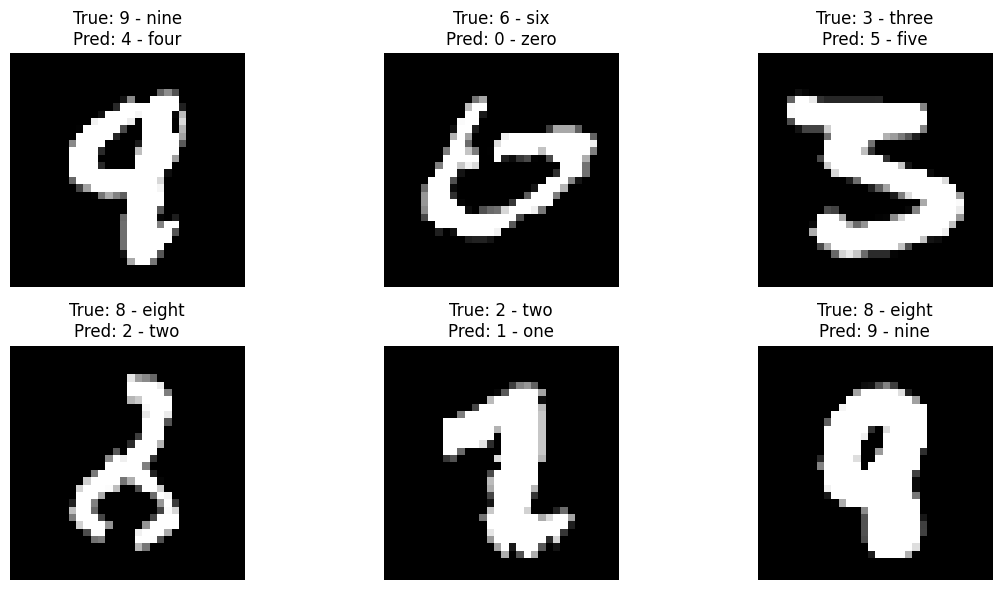

Model - $VGG19 (plain)
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


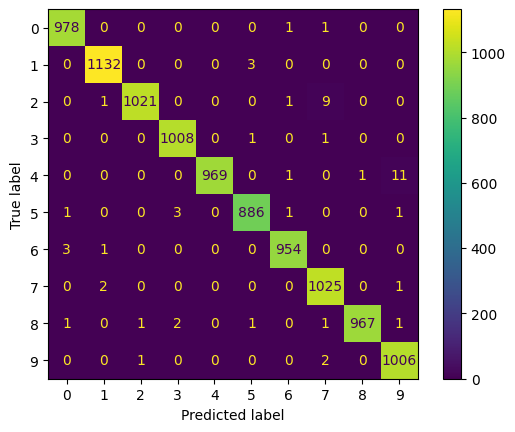

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.790561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8121893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7818604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8008037].


              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       1.00      0.99      0.99      1032
   3 - three       1.00      1.00      1.00      1010
    4 - four       1.00      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      1.00      1.00       958
   7 - seven       0.99      1.00      0.99      1028
   8 - eight       1.00      0.99      1.00       974
    9 - nine       0.99      1.00      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



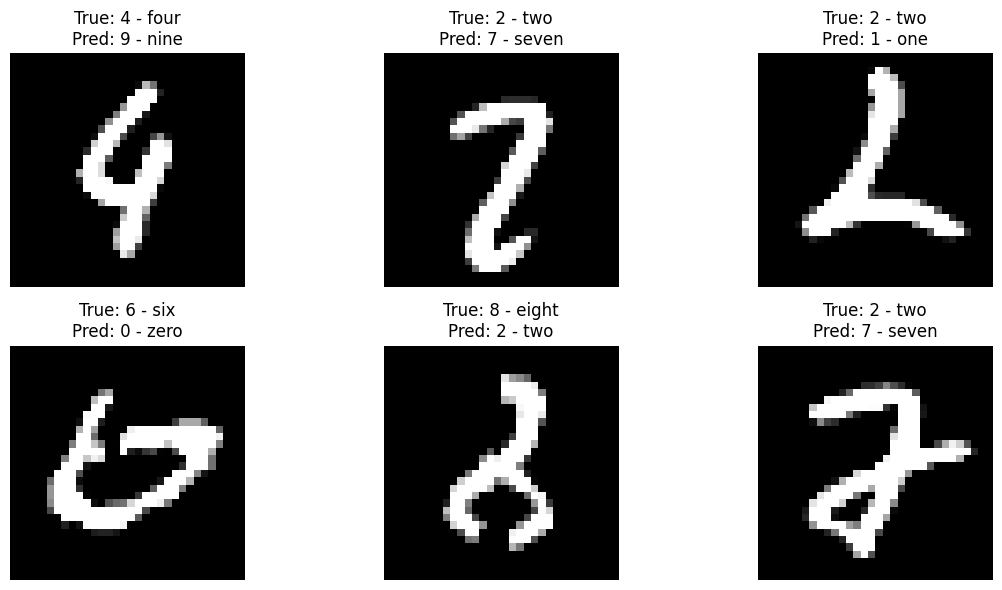

Model - $VGG19_BN
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


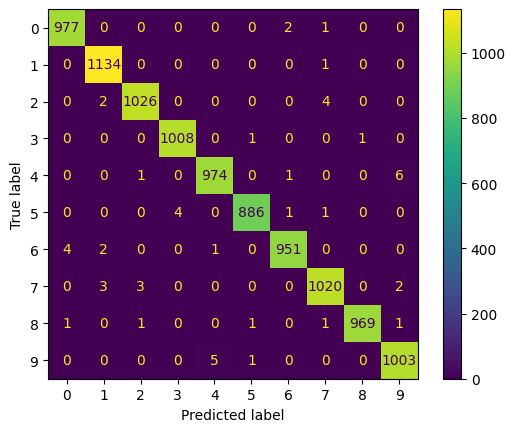

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.790561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8121893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8198957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8008037].


              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       1.00      0.99      0.99      1032
   3 - three       1.00      1.00      1.00      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       1.00      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       1.00      0.99      1.00       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



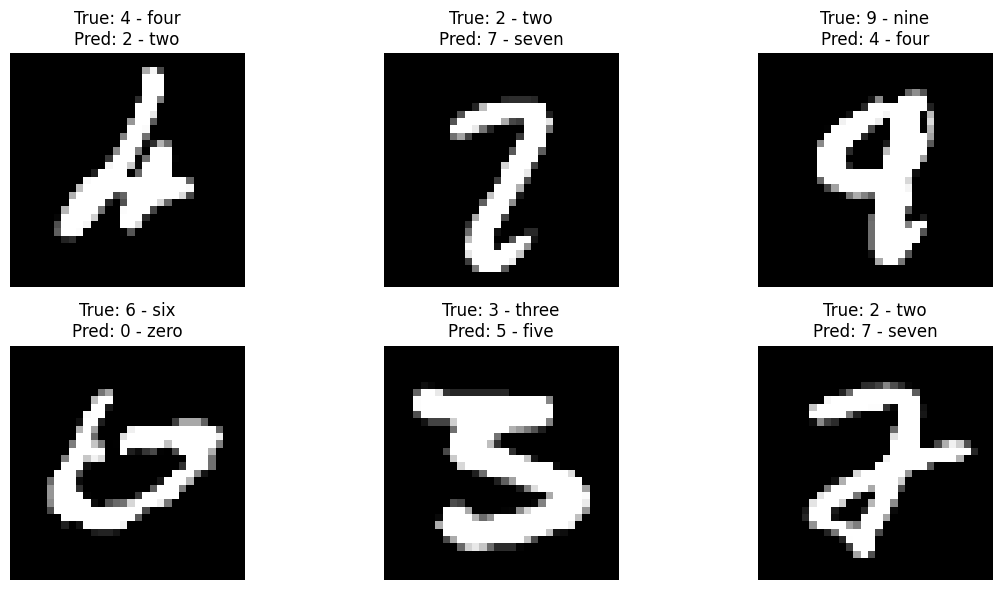

Model - $ResNet18
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


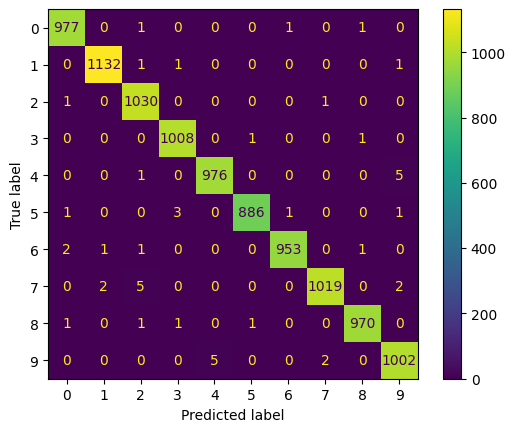

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8020961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.790561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8091066].


              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       0.99      1.00      0.99      1032
   3 - three       1.00      1.00      1.00      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       1.00      0.99      1.00       892
     6 - six       1.00      0.99      1.00       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       1.00      1.00      1.00       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



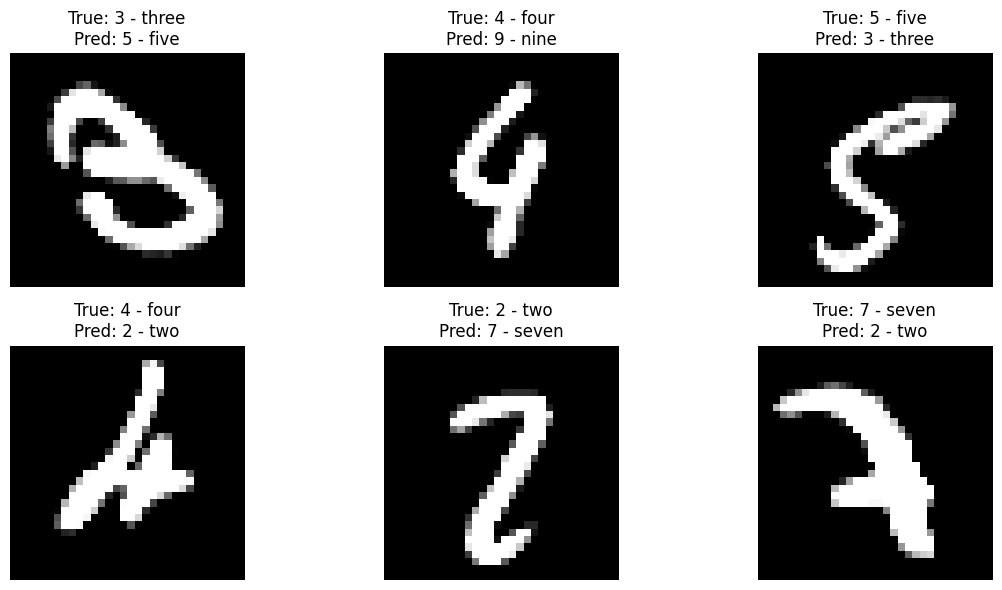

Model - $ResNet50
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.67 GB


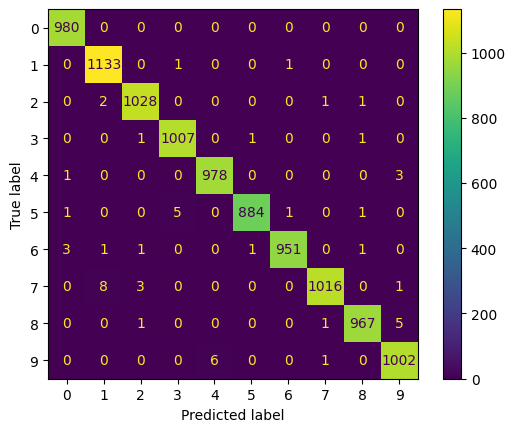

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8121893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8029413].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8023944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].


              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      1.00      1.00      1032
   3 - three       0.99      1.00      1.00      1010
    4 - four       0.99      1.00      0.99       982
    5 - five       1.00      0.99      0.99       892
     6 - six       1.00      0.99      1.00       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       1.00      0.99      0.99       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



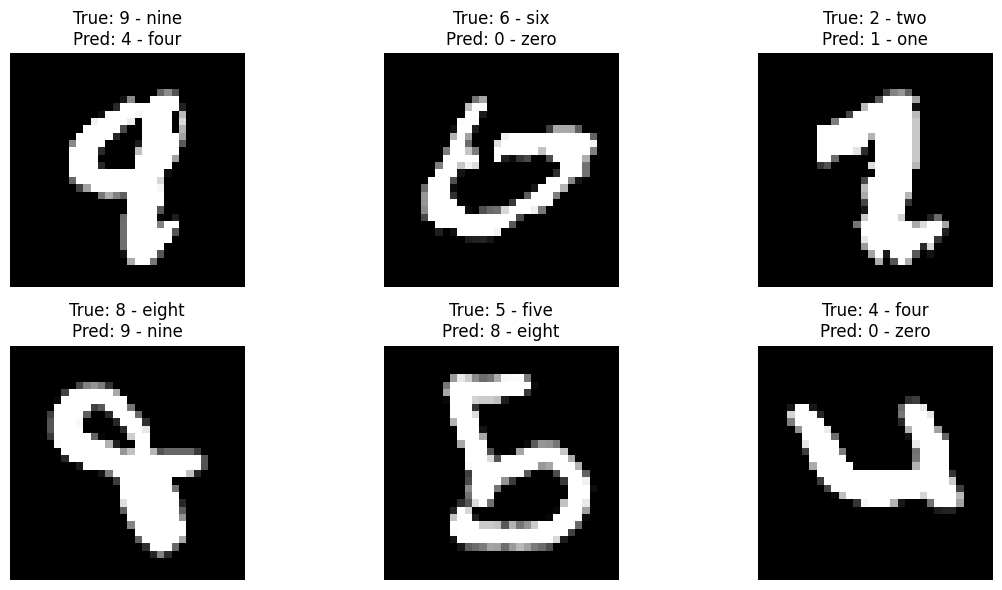

In [52]:

device = get_device()
for name, model, ds in experiments:
    # print(ds, name)
    if ds == "MNIST":
        print("==="*33)
        print(f"Model - ${name}")
        model.to(device).eval()
        clear_gpu_memory()
        get_gpu_memory()
        train_dl, test_dl, n_cls = get_dataloaders(ds, batch_size=64)
        class_names = test_dl.dataset.classes
        
        y_true, y_pred = get_predictions(model, test_dl, device)
    
        plot_reports(class_names, y_true, y_pred, name, ds)
        visual_fails(y_pred, y_true, test_dl, model)
        
        
   

## CIFAR10

Model - $VGG16 (plain)
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


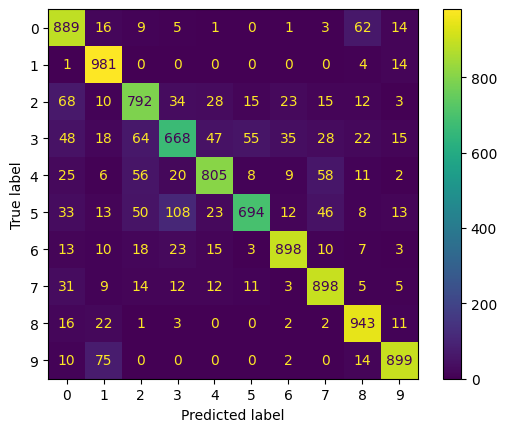

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2019196..2.734221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..2.6171591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1238415..2.4171634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.398588..2.7147107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.2233143].


              precision    recall  f1-score   support

    airplane       0.78      0.89      0.83      1000
  automobile       0.85      0.98      0.91      1000
        bird       0.79      0.79      0.79      1000
         cat       0.77      0.67      0.71      1000
        deer       0.86      0.81      0.83      1000
         dog       0.88      0.69      0.78      1000
        frog       0.91      0.90      0.90      1000
       horse       0.85      0.90      0.87      1000
        ship       0.87      0.94      0.90      1000
       truck       0.92      0.90      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



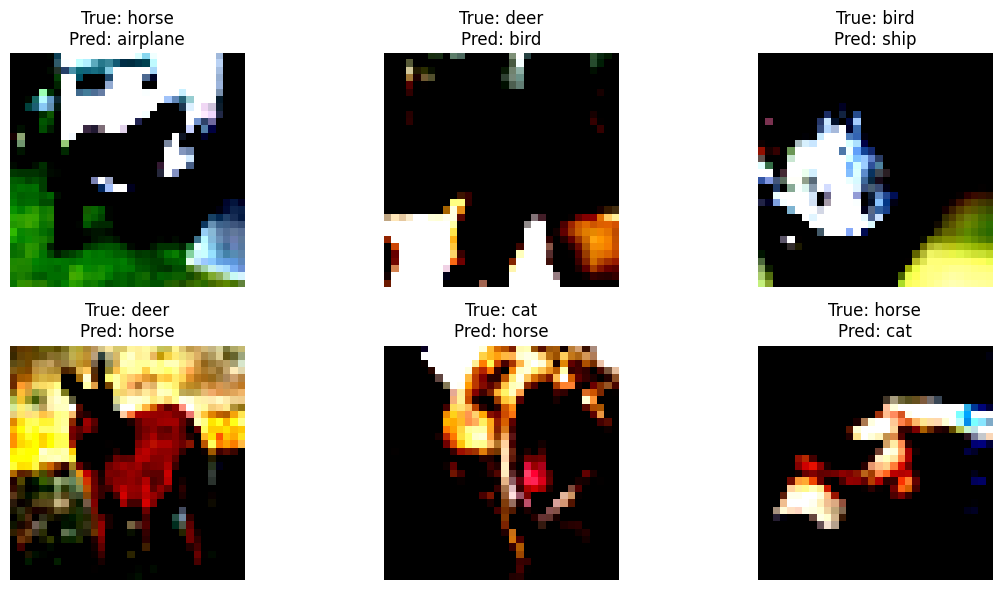

Model - $VGG16_BN
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


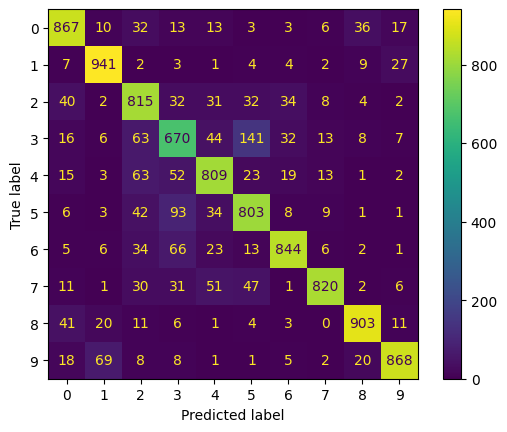

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7699786..2.3590088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2215865..2.5781386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1302763..2.3607883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0025976..1.7968462].


              precision    recall  f1-score   support

    airplane       0.85      0.87      0.86      1000
  automobile       0.89      0.94      0.91      1000
        bird       0.74      0.81      0.78      1000
         cat       0.69      0.67      0.68      1000
        deer       0.80      0.81      0.81      1000
         dog       0.75      0.80      0.78      1000
        frog       0.89      0.84      0.86      1000
       horse       0.93      0.82      0.87      1000
        ship       0.92      0.90      0.91      1000
       truck       0.92      0.87      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



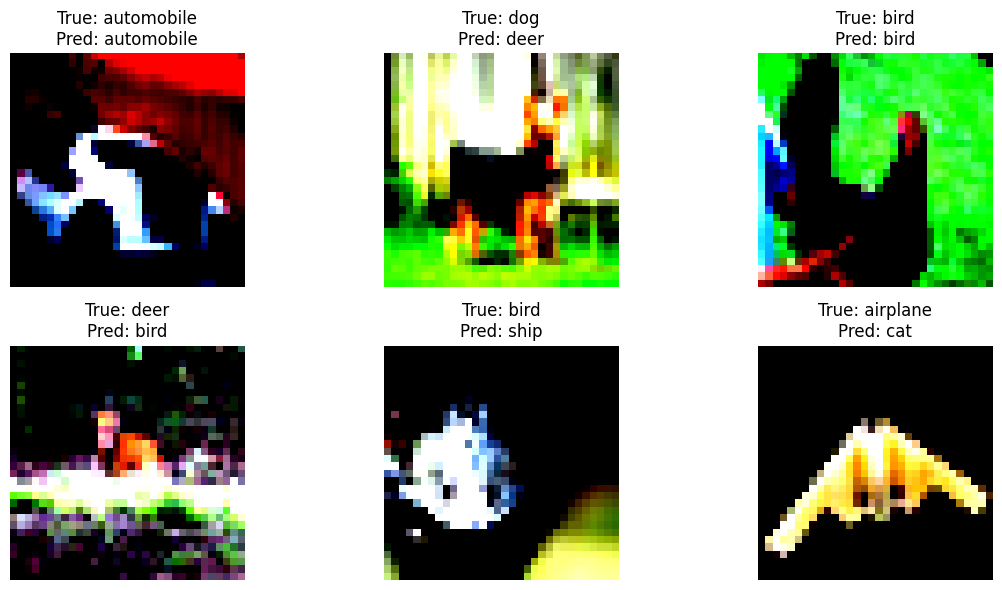

Model - $VGG19 (plain)
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


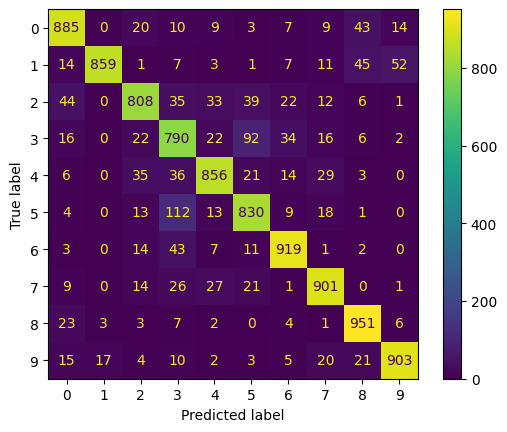

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..2.6171591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3127563..2.402546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0025976..1.7968462].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.2233143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7921666..2.7147107].


              precision    recall  f1-score   support

    airplane       0.87      0.89      0.88      1000
  automobile       0.98      0.86      0.91      1000
        bird       0.87      0.81      0.84      1000
         cat       0.73      0.79      0.76      1000
        deer       0.88      0.86      0.87      1000
         dog       0.81      0.83      0.82      1000
        frog       0.90      0.92      0.91      1000
       horse       0.89      0.90      0.89      1000
        ship       0.88      0.95      0.92      1000
       truck       0.92      0.90      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



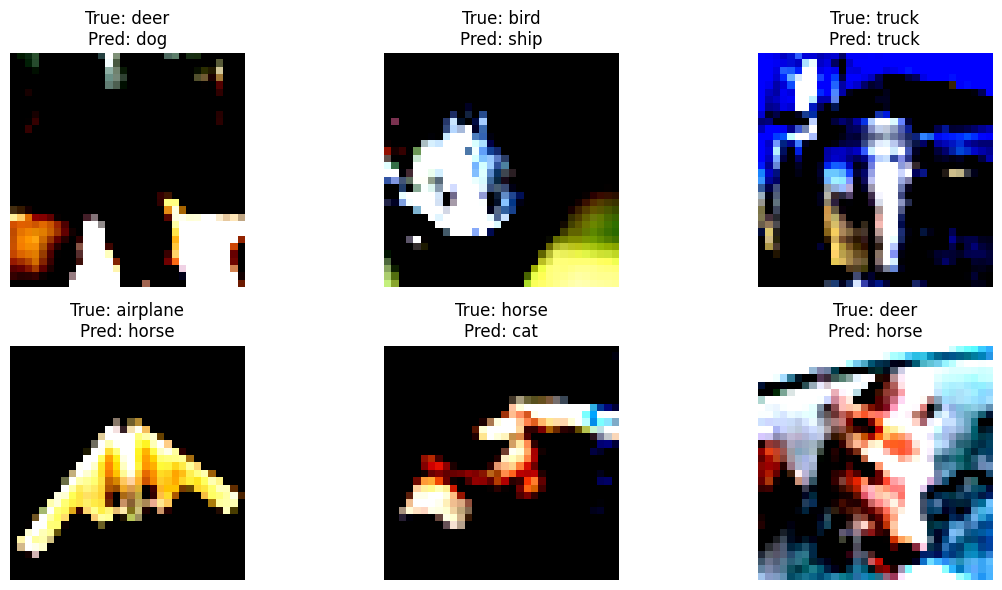

Model - $VGG19_BN
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


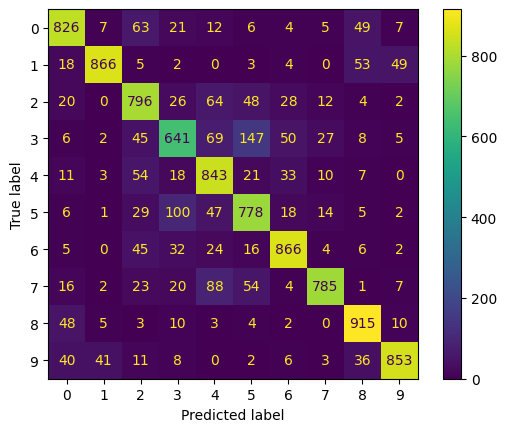

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..1.5642271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0219827..1.7196859].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7699786..2.3590088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2215865..2.5781386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].


              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.93      0.87      0.90      1000
        bird       0.74      0.80      0.77      1000
         cat       0.73      0.64      0.68      1000
        deer       0.73      0.84      0.78      1000
         dog       0.72      0.78      0.75      1000
        frog       0.85      0.87      0.86      1000
       horse       0.91      0.79      0.84      1000
        ship       0.84      0.92      0.88      1000
       truck       0.91      0.85      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



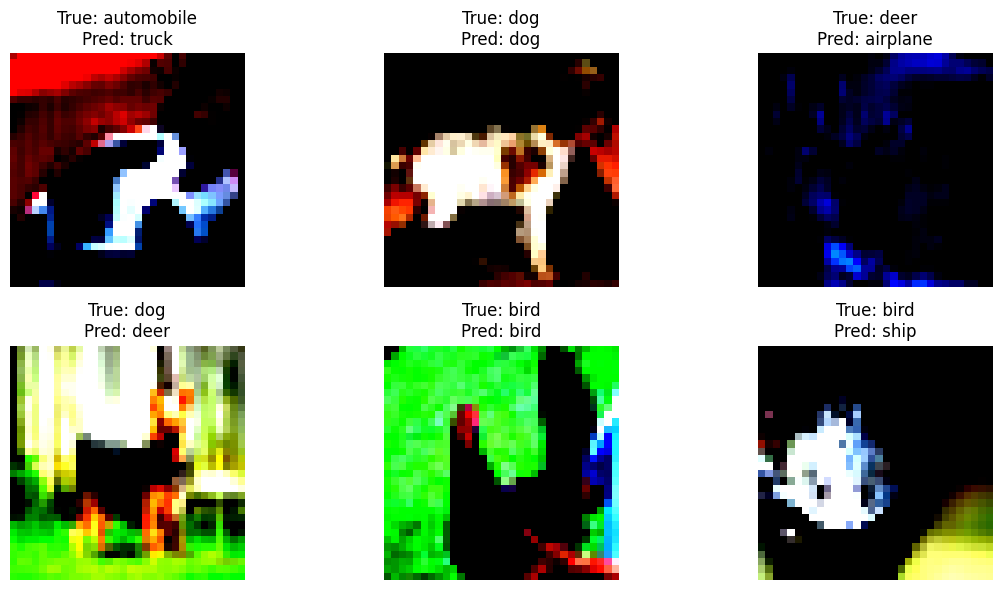

Model - $ResNet18
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


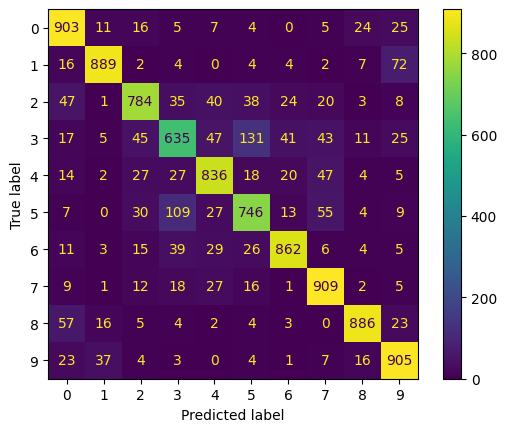

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7699786..2.3590088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3127563..2.65618].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3592544..2.7147107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7921666..2.7147107].


              precision    recall  f1-score   support

    airplane       0.82      0.90      0.86      1000
  automobile       0.92      0.89      0.90      1000
        bird       0.83      0.78      0.81      1000
         cat       0.72      0.64      0.68      1000
        deer       0.82      0.84      0.83      1000
         dog       0.75      0.75      0.75      1000
        frog       0.89      0.86      0.88      1000
       horse       0.83      0.91      0.87      1000
        ship       0.92      0.89      0.90      1000
       truck       0.84      0.91      0.87      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000



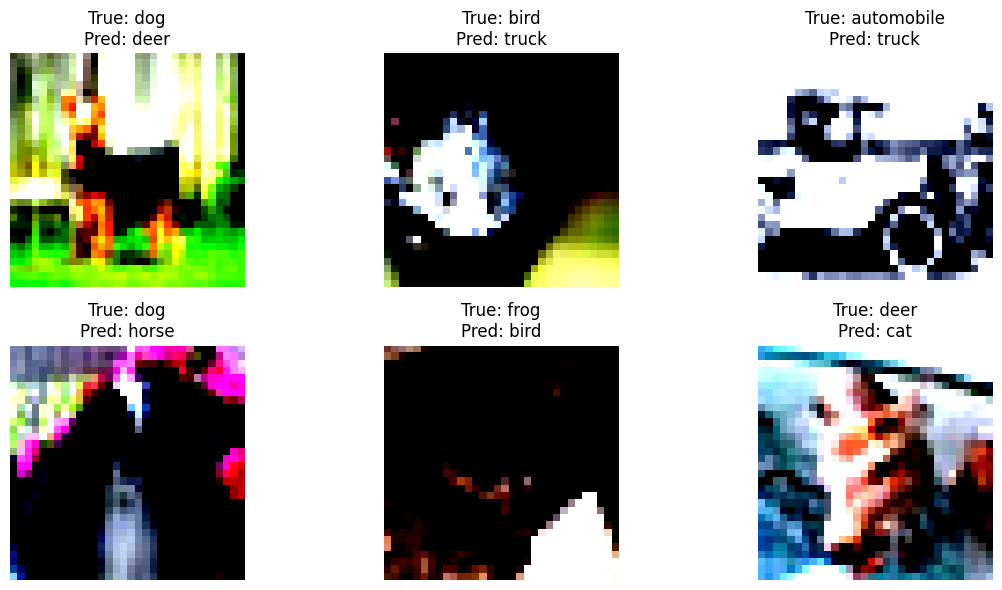

Model - $ResNet50
GPU memory allocated: 0.64 GB
GPU memory reserved: 0.69 GB


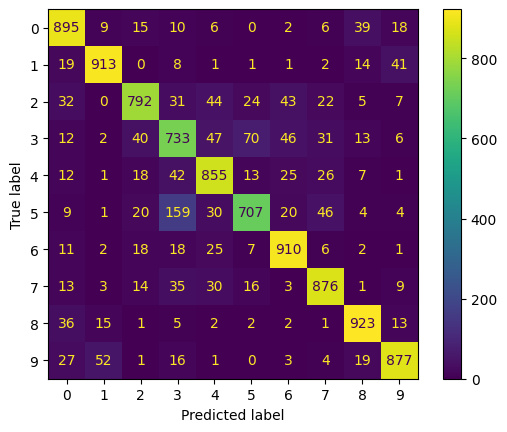

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2019196..2.734221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2215865..2.5781386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5196078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3127563..2.65618].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0025976..1.7968462].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7921666..2.7147107].


              precision    recall  f1-score   support

    airplane       0.84      0.90      0.87      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.86      0.79      0.83      1000
         cat       0.69      0.73      0.71      1000
        deer       0.82      0.85      0.84      1000
         dog       0.84      0.71      0.77      1000
        frog       0.86      0.91      0.89      1000
       horse       0.86      0.88      0.87      1000
        ship       0.90      0.92      0.91      1000
       truck       0.90      0.88      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



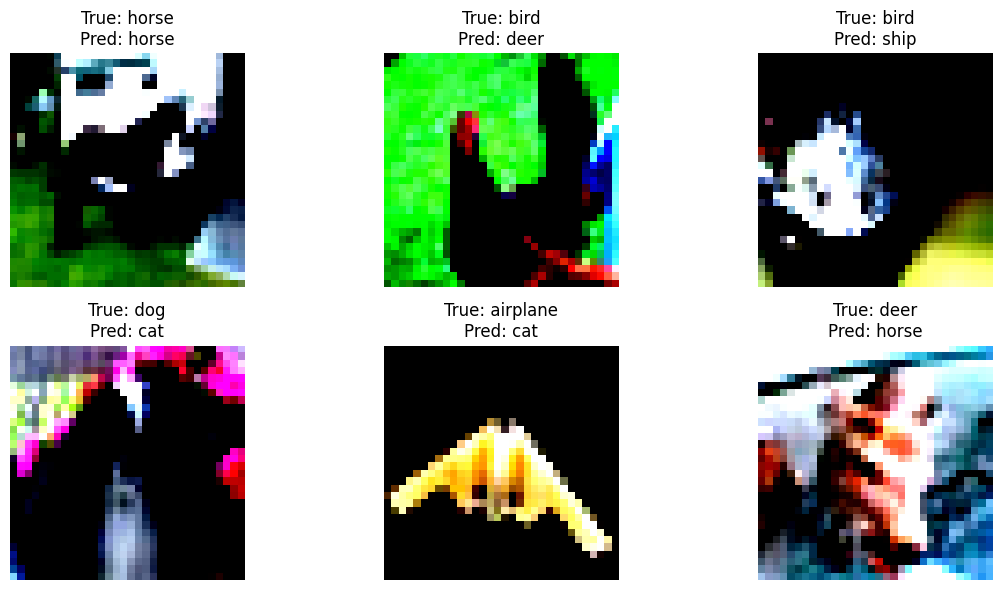

In [11]:

device = get_device()
for name, model, ds in experiments:
    # print(ds, name)
    if ds != "MNIST":
        print("==="*33)
        print(f"Model - ${name}")
        model.to(device).eval()
        clear_gpu_memory()
        get_gpu_memory()
        train_dl, test_dl, n_cls = get_dataloaders(ds, batch_size=64)
        class_names = test_dl.dataset.classes
        
        y_true, y_pred = get_predictions(model, test_dl, device)
    
        plot_reports(class_names, y_true, y_pred, name, ds)
        visual_fails(y_pred, y_true, test_dl, model)
        # break
   

## Plots for paper

In [12]:
# set plots styles for paper
import matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

# Customize rcParams for finer control
matplotlib.rc('font', family='DejaVu Sans')
# matplotlib.rc('font', family='Arial')  # or another preferred font family
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Thicker lines and markers for clarity
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['axes.linewidth'] = 1.5


In [13]:
import pandas as pd

from matplotlib import pyplot as plt

In [14]:
# mnist data
vgg16_path = "vgg_results/mnist_vgg16_scratch_metrics.csv"
vgg19_path = "vgg_results/mnist_vgg19_scratch_metrics.csv"
vgg16_df = pd.read_csv(vgg16_path)
vgg19_df = pd.read_csv(vgg19_path)

vgg16_bn_path = "vgg_bottleneck_results/mnist_vgg16_bottleneck_scratch_metrics.csv"
vgg19_bn_path = "vgg_bottleneck_results/mnist_vgg19_bottleneck_scratch_metrics.csv"
vgg16_bn_df = pd.read_csv(vgg16_bn_path)
vgg19_bn_df = pd.read_csv(vgg19_bn_path)

resnet18_path = "resnet_results/mnist_resnet18_scratch_metrics.csv"
resnet50_path = "resnet_results/mnist_resnet50_scratch_metrics.csv"
resnet18_df = pd.read_csv(resnet18_path)
resnet50_df = pd.read_csv(resnet50_path)

dfs_mnist = {
    "VGG16":      vgg16_df,
    "VGG19":      vgg19_df,
    "VGG16‑BN":   vgg16_bn_df,
    "VGG19‑BN":   vgg19_bn_df,
    "ResNet18":   resnet18_df,
    "ResNet50":   resnet50_df,
}

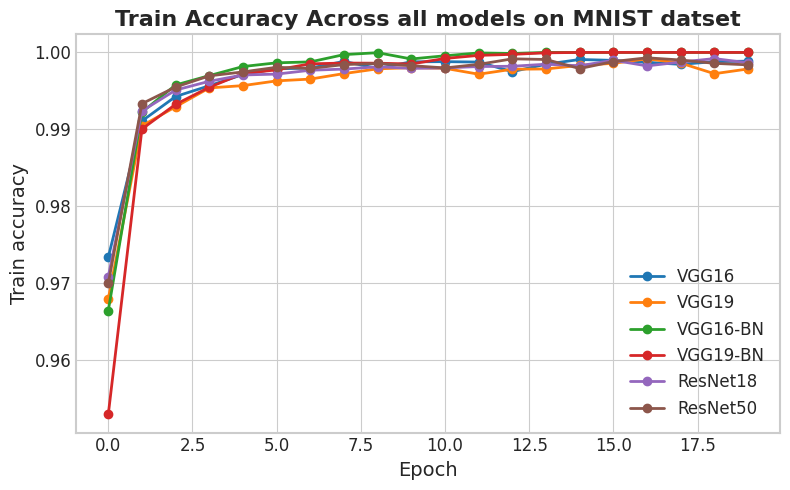

In [15]:
plt.figure(figsize=(8, 5))

for name, df in dfs_mnist.items():
    acc = df["train_acc"].iloc[:20]
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.title("Train Accuracy Across all models on MNIST datset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('img/mnist_train_acc.png')
plt.show()

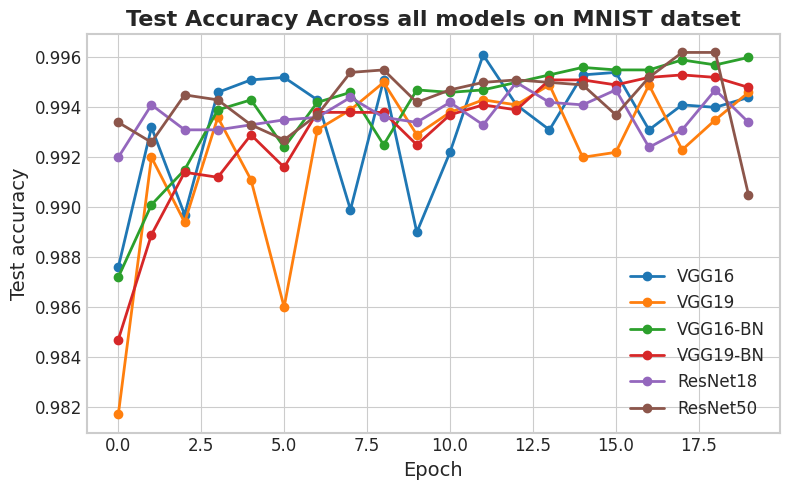

In [65]:
plt.figure(figsize=(8, 5))

for name, df in dfs_mnist.items():
    acc = df["test_acc"].iloc[:20]
    # epochs = range(1, len(acc) + 1)
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy Across all models on MNIST datset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('img/mnist_test_acc.png')
plt.show()

In [16]:
# cifar10 data
vgg16_path = "vgg_results/cifar10_vgg16_scratch_metrics.csv"
vgg19_path = "vgg_results/cifar10_vgg19_scratch_metrics.csv"
vgg16_df = pd.read_csv(vgg16_path)
vgg19_df = pd.read_csv(vgg19_path)

vgg16_bn_path = "vgg_bottleneck_results/cifar10_vgg16_bottleneck_scratch_metrics.csv"
vgg19_bn_path = "vgg_bottleneck_results/cifar10_vgg19_bottleneck_scratch_metrics.csv"
vgg16_bn_df = pd.read_csv(vgg16_bn_path)
vgg19_bn_df = pd.read_csv(vgg19_bn_path)

resnet18_path = "resnet_results/cifar10_resnet18_scratch_metrics.csv"
resnet50_path = "resnet_results/cifar10_resnet50_scratch_metrics.csv"
resnet18_df = pd.read_csv(resnet18_path)
resnet50_df = pd.read_csv(resnet50_path)

dfs_cifar10 = {
    "VGG16":      vgg16_df,
    "VGG19":      vgg19_df,
    "VGG16‑BN":   vgg16_bn_df,
    "VGG19‑BN":   vgg19_bn_df,
    "ResNet18":   resnet18_df,
    "ResNet50":   resnet50_df,
}

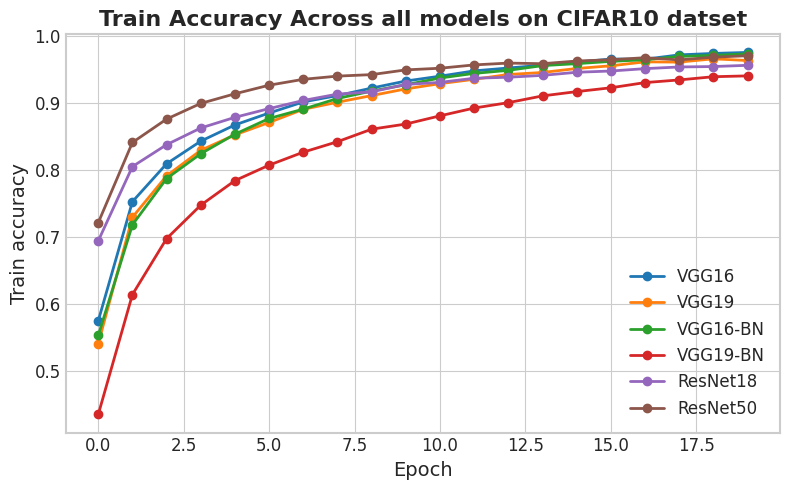

In [17]:
plt.figure(figsize=(8, 5))

for name, df in dfs_cifar10.items():
    acc = df["train_acc"].iloc[:20]
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.title("Train Accuracy Across all models on CIFAR10 datset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('img/cifar10_train_acc.png')
plt.show()

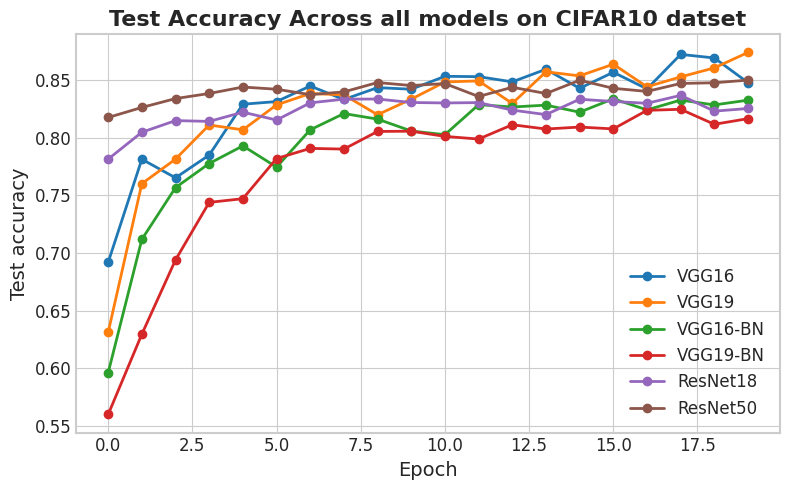

In [18]:
plt.figure(figsize=(8, 5))

for name, df in dfs_cifar10.items():
    acc = df["test_acc"].iloc[:20]
    # epochs = range(1, len(acc) + 1)
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy Across all models on CIFAR10 datset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('img/cifar10_test_acc.png')
plt.show()

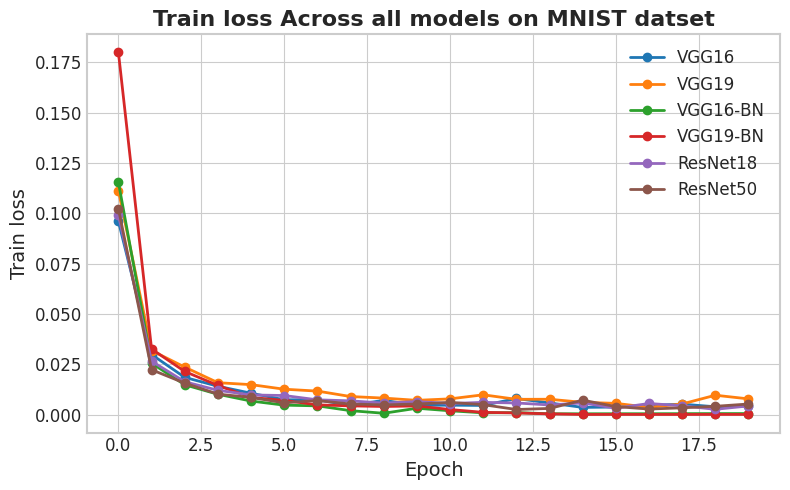

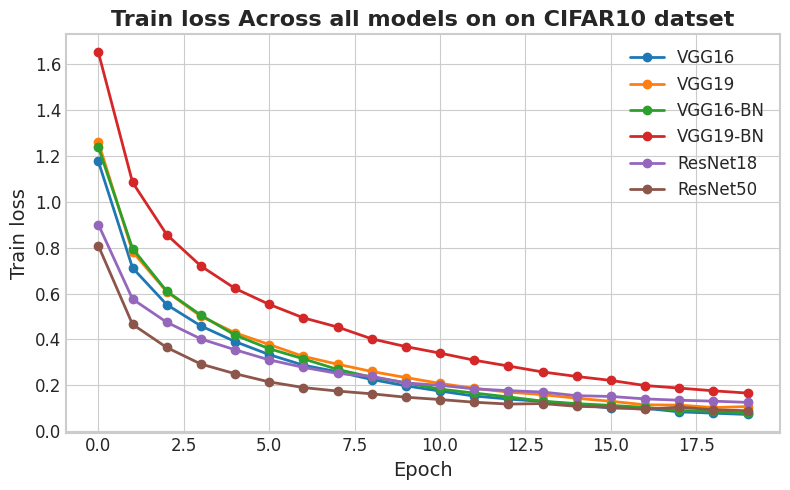

In [20]:
# loss

plt.figure(figsize=(8, 5))

for name, df in dfs_mnist.items():
    acc = df["train_loss"].iloc[:20]
    # epochs = range(1, len(acc) + 1)
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Train loss Across all models on MNIST datset")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('img/mnist_train_loss.png')
plt.show()


plt.figure(figsize=(8, 5))

for name, df in dfs_cifar10.items():
    acc = df["train_loss"].iloc[:20]
    # epochs = range(1, len(acc) + 1)
    plt.plot( acc, marker='o', label=name)

plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Train loss Across all models on on CIFAR10 datset")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('img/cifar10_train_loss.png')
plt.show()

In [22]:
!pip install ace_tools

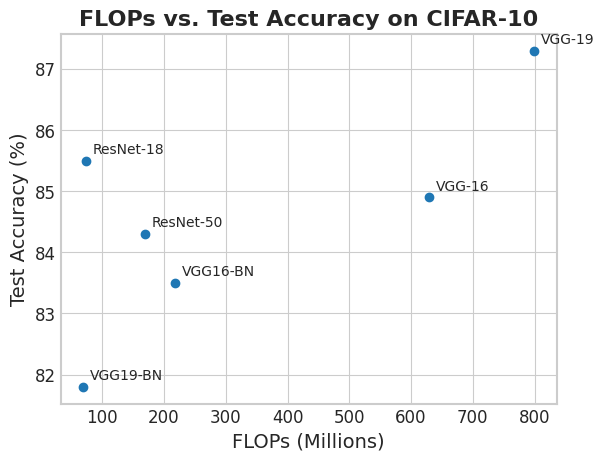

In [25]:

#  data for CIFAR-10 models
data = {
    'Model': ['VGG-16', 'VGG-19', 'ResNet-18', 'ResNet-50', 'VGG16-BN', 'VGG19-BN'],
    'FLOPs (M)': [629, 799, 74, 169, 218, 69],
    'Accuracy (%)': [84.9, 87.3, 85.5, 84.3, 83.5, 81.8]
}

df = pd.DataFrame(data)

plt.figure()
plt.scatter(df['FLOPs (M)'], df['Accuracy (%)'])
for i, row in df.iterrows():
    plt.annotate(row['Model'], (row['FLOPs (M)'], row['Accuracy (%)']), 
                 textcoords="offset points", xytext=(5,5))
plt.xlabel('FLOPs (Millions)')
plt.ylabel('Test Accuracy (%)')
plt.title('FLOPs vs. Test Accuracy on CIFAR-10')
plt.savefig('img/cifar10_flops_vs_accuracy.png')
plt.show()
